In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import yfinance as yf
import seaborn as sb
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, SpatialDropout1D, Embedding, LSTM, GRU, Bidirectional, Dropout, Convolution1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, MaxPooling1D

In [ ]:
import datetime
start= '2010-01-01'
end= '2019-12-31'
dataset=yf.download('AAPL',start,end)
#dataset=data.DataReader('TSLA', 'yahoo', start, datetime.date.today())
dataset.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516526,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412872,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401017,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443573,447610800


In [ ]:
dataset=dataset.reset_index()
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516526,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412872,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401017,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443573,447610800
...,...,...,...,...,...,...,...
2510,2019-12-23,70.132500,71.062500,70.092499,71.000000,69.451065,98572000
2511,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517105,48478800
2512,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896324,93121200
2513,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869415,146266000


In [ ]:
dataset.shape

(2515, 7)

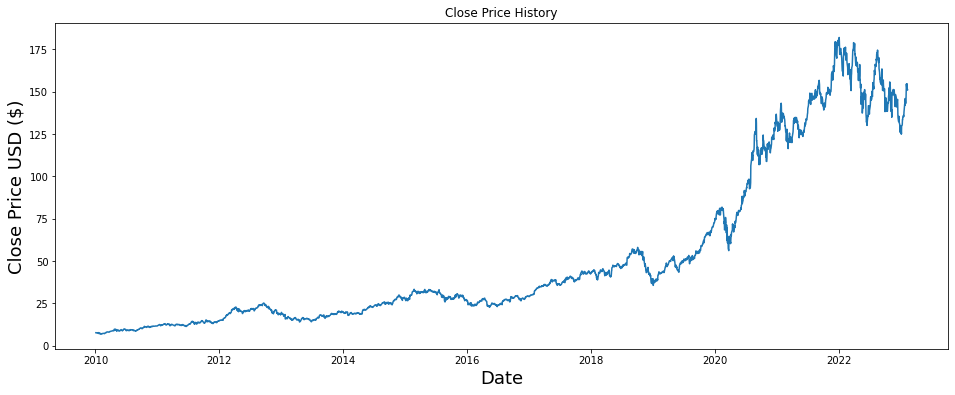

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(dataset['Date'],dataset['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(dataset[col])
plt.show()

In [ ]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(dataset[col])
plt.show()

In [ ]:
#moving average (30 days)
ma30=dataset.Close.rolling(100).mean()
ma30

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
3295    142.811599
3296    142.804999
3297    142.800499
3298    142.802199
3299    142.767499
Name: Close, Length: 3300, dtype: float64

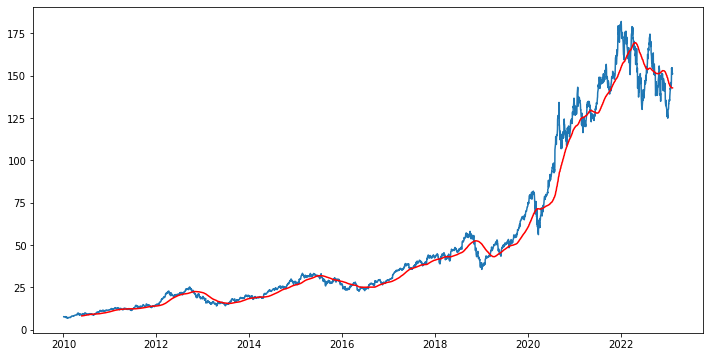

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dataset.Date,dataset.Close)
plt.plot(dataset.Date,ma30,'r')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [ ]:
train_data=pd.DataFrame(dataset['Close'][0:int(len(dataset)*.70)])
test_data=pd.DataFrame(dataset['Close'][int(len(dataset)*.70):int(len(dataset))])
print(train_data.shape,test_data.shape)

(1760, 1) (755, 1)


In [ ]:
training_data=scaler.fit_transform(train_data)
training_data

array([[0.02971782],
       [0.03021854],
       [0.02560389],
       ...,
       [0.84388656],
       [0.85089656],
       [0.84616011]])

In [ ]:
training_data.shape

(2310, 1)

In [ ]:
time_step=100
x_train=[]
y_train=[]

for i in range(time_step,training_data.shape[0]):
  x_train.append(training_data[i-time_step: i])
  y_train.append(training_data[i, 0])

In [ ]:
x_train, y_train =np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape

(2210, 100, 1)

In [ ]:
from sklearn import metrics
# Build the LSTM model
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.5))

#model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
#checkpointer = ModelCheckpoint(filepath="model2.h5", verbose=1, save_best_only=True, monitor='loss',mode='min')
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
52/52 [==============================] - 24s 320ms/step - loss: 0.0664
Epoch 2/50
52/52 [==============================] - 17s 323ms/step - loss: 0.0136
Epoch 3/50
52/52 [==============================] - 18s 337ms/step - loss: 0.0110
Epoch 4/50
52/52 [==============================] - 17s 323ms/step - loss: 0.0095
Epoch 5/50
52/52 [==============================] - 17s 322ms/step - loss: 0.0099
Epoch 6/50
52/52 [==============================] - 18s 342ms/step - loss: 0.0086
Epoch 7/50
52/52 [==============================] - 17s 322ms/step - loss: 0.0086
Epoch 8/50
52/52 [==============================] - 17s 337ms/step - loss: 0.0079
Epoch 9/50
52/52 [==============================] - 18s 335ms/step - loss: 0.0089
Epoch 10/50
52/52 [==============================] - 17s 324ms/step - loss: 0.0076
Epoch 11/50
52/52 [==============================] - 17s 336ms/step - loss: 0.0073
Epoch 12/50
52/52 [==============================] - 17s 329ms/step - loss: 0.0078
Epoch 13/50
5

In [ ]:
model.save('keras_model.h5')

In [ ]:
past_time_index=train_data.tail(time_step)
final_test_data=past_time_index.append(test_data,ignore_index=True)

In [ ]:
final_test_data

In [ ]:
final_testing_data=scaler.fit_transform(final_test_data)

In [ ]:
x_test=[]
y_test=[]

for i in range(time_step,final_testing_data.shape[0]):
  x_test.append(final_testing_data[i-time_step: i])
  y_test.append(final_testing_data[i, 0])

In [ ]:
x_test, y_test= np.array(x_test), np.array(y_test)
print(x_test.shape, y_test.shape)

(755, 100, 1) (755,)


In [ ]:
y_pred=model.predict(x_test)

24/24 [==============================] - 3s 89ms/step


In [ ]:
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_pred)

In [ ]:
scale_factor=1/scaler.scale_
y_pred=y_pred * scale_factor
y_test=y_test * scale_factor

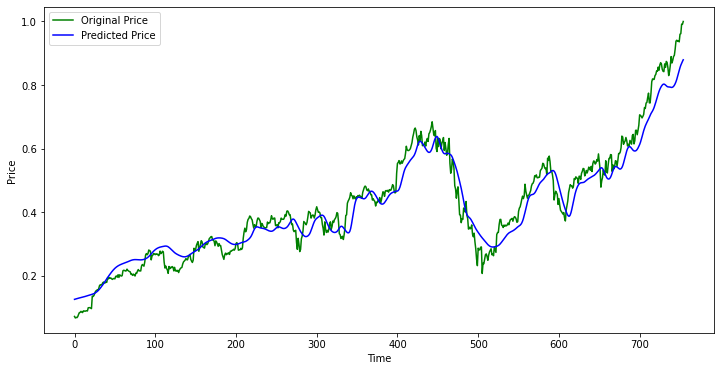

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'g', label ='Original Price')
plt.plot(y_pred,'blue', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error


### Test Data RMSE
math.sqrt(mean_squared_error(y_test,y_pred))

7194.39523269159

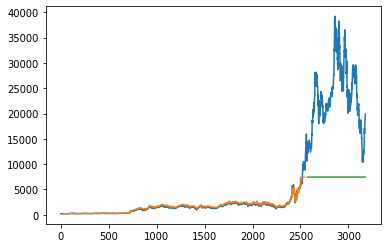

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()